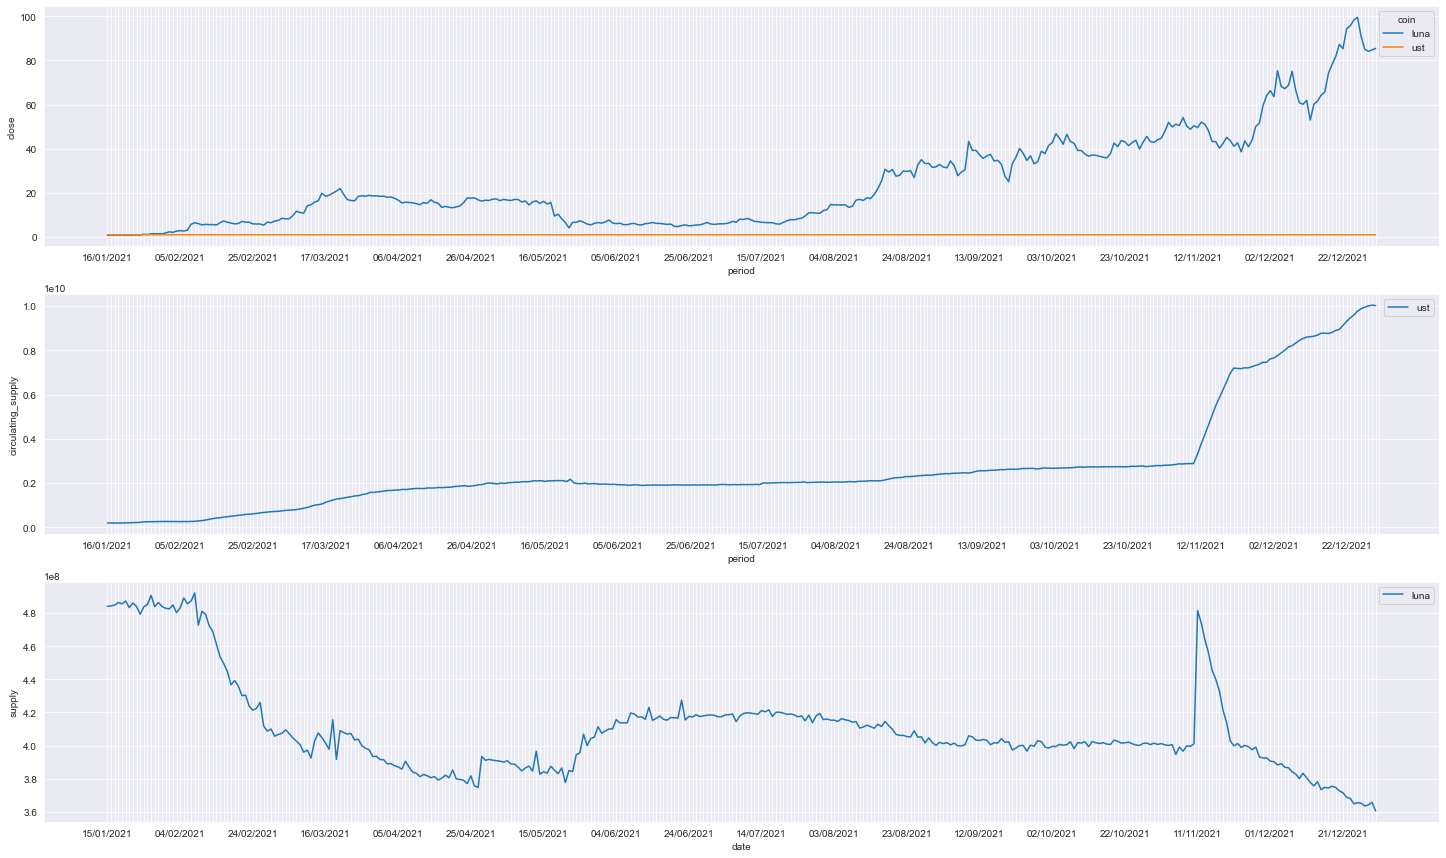

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
from pycoingecko import CoinGeckoAPI
from datetime import date
import datetime

scope = pd.read_csv(r"/Users/fernandoseguias/Desktop/ferseg/Proyectos/Programacion/iron_hack/project_1/output/scope.csv")

luna_scope = scope.loc[scope["coin"] == "luna"]
luna_scope["coin"] = "luna"
ust_scope = scope.loc[scope["coin"] == "ust"]
ust_scope["coin"] = "ust"
scope = pd.concat([luna_scope.tail(350), ust_scope.tail(350)], join='outer')
scope["period"] = scope["date"].astype("str")

#api link to download important missing data about luna supply
cg = CoinGeckoAPI()

from_ = date(2018, 12, 31)
to_ = date(2021, 12, 31)

unix_from = from_.strftime('%s')
unix_to = to_.strftime('%s')

df = pd.DataFrame(cg.get_coin_market_chart_range_by_id(id="terra-luna", vs_currency="usd", from_timestamp=unix_from, to_timestamp=unix_to))

def mc_transfor(df):
    df[['date','price']] = pd.DataFrame(df.prices.tolist(), index= df.index) #get values in lists and drop old colums
    df['market_cap'] = df["market_caps"].apply(lambda x : x[1])
    df['total_volume'] = df["total_volumes"].apply(lambda x : x[1])
    df.drop(["prices", "market_caps", "total_volumes"], axis=1, inplace=True)

    df["date"] = df["date"].apply(lambda x : datetime.datetime.fromtimestamp(x / 1e3)) #change types: date to datetime / coin to category / floats to round float
    df["date"] = df["date"].dt.strftime('%d/%m/%Y')
    df["price"] = df["price"].astype(float).round(5)
    df[["market_cap", "total_volume"]] = df[["market_cap", "total_volume"]].astype(int)
    df["supply"] = df["market_cap"] / df["price"]
    return df

mc_transfor(df)

#luna and ust price - note that ust is pegged to us dollar
fig, axes = plt.subplots(3, 1, figsize=(25, 15), sharex=False, sharey=False)
fig = sns.lineplot(data=scope, x="period", y="close", hue="coin", ax=axes[0])
for ind, label in enumerate(fig.get_xticklabels()):
    if ind % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

ust_scope = scope.loc[scope["coin"] == "ust"]
fig = sns.lineplot(data=ust_scope, x="period", y="circulating_supply", ax=axes[1], label="ust")
for ind, label in enumerate(fig.get_xticklabels()):
    if ind % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

luna_scope = df.tail(350)
fig = sns.lineplot(data=luna_scope, x="date", y="supply", ax=axes[2], label="luna")
for ind, label in enumerate(fig.get_xticklabels()):
    if ind % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)